In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from scipy import stats

In [24]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

# 1. Обработка данных

In [2]:
df = pd.read_csv('pollution.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43824 entries, 0 to 43823
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   No      43824 non-null  int64  
 1   year    43824 non-null  int64  
 2   month   43824 non-null  int64  
 3   day     43824 non-null  int64  
 4   hour    43824 non-null  int64  
 5   pm2.5   41757 non-null  float64
 6   DEWP    43824 non-null  int64  
 7   TEMP    43824 non-null  float64
 8   PRES    43824 non-null  float64
 9   cbwd    43824 non-null  object 
 10  Iws     43824 non-null  float64
 11  Is      43824 non-null  int64  
 12  Ir      43824 non-null  int64  
dtypes: float64(4), int64(8), object(1)
memory usage: 4.3+ MB


In [4]:
df['pm2.5'].isna().sum()

2067

In [5]:
df = df[24:].fillna(method='ffill')
df['pm2.5'].isna().sum()

0

In [6]:
import datetime

df['time'] = df.apply(lambda x : datetime.datetime(year=x['year'], month=x['month'], day=x['day'], hour=x['hour']), axis=1)
df.drop(columns=['year', 'month', 'day', 'hour', 'No'], inplace=True)
df = df.set_index('time')
df.head()

,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
time,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


In [7]:
df['cbwd'].unique()

array(['SE', 'cv', 'NW', 'NE'], dtype=object)

In [8]:
df = df.join((pd.get_dummies(df['cbwd'])).astype(int)) # one-hot encoding
del df['cbwd']
df.head()

,pm2.5,DEWP,TEMP,PRES,Iws,Is,Ir,NE,NW,SE,cv
time,,,,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,1.79,0,0,0,0,1,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,2.68,0,0,0,0,1,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,3.57,0,0,0,0,1,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,5.36,1,0,0,0,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,6.25,2,0,0,0,1,0


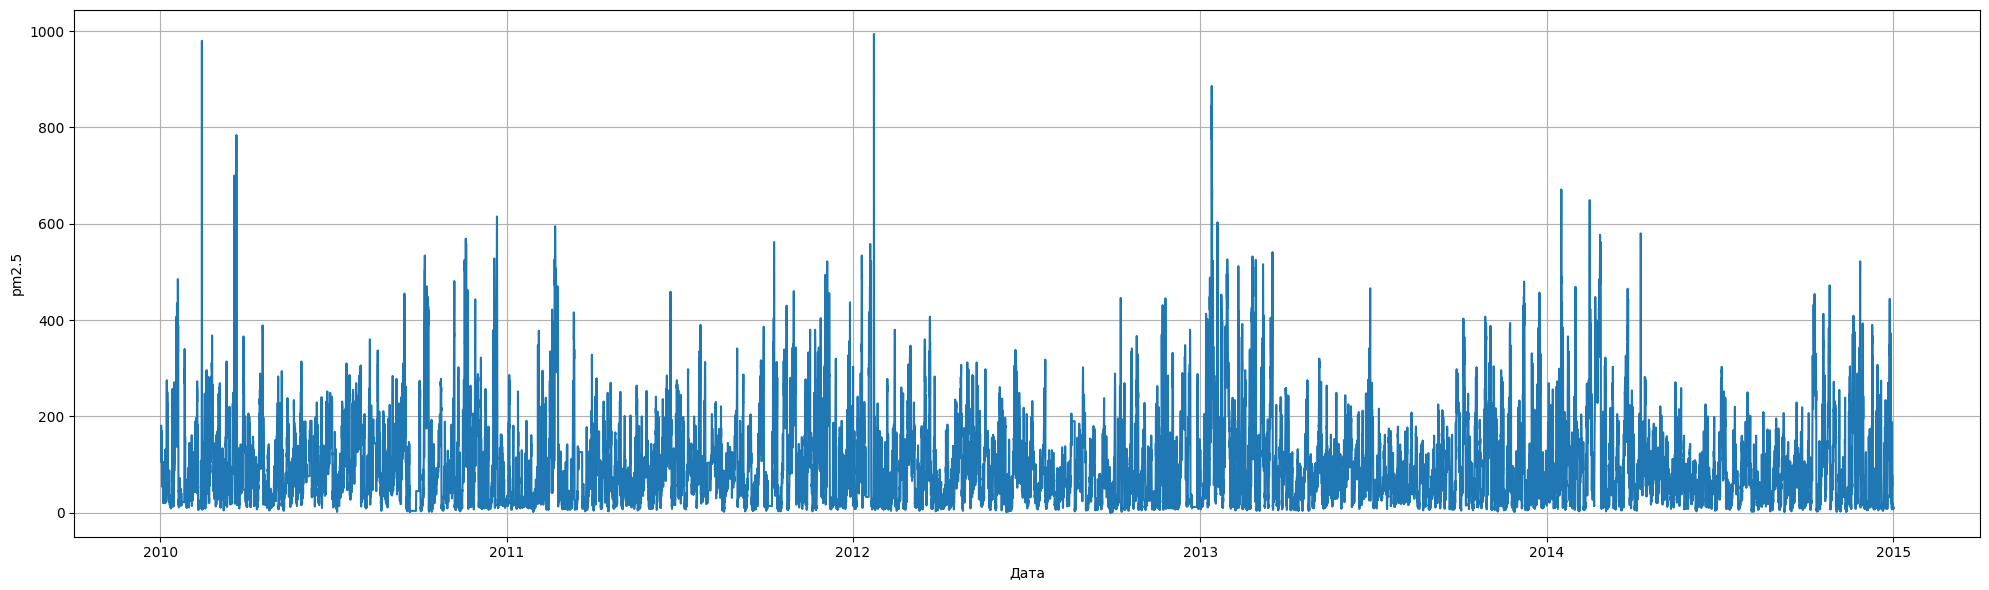

In [11]:
plt.figure(figsize=(20, 6))
plt.plot(df['pm2.5'])
plt.xlabel('Дата')
plt.ylabel('pm2.5')
plt.grid(True)
plt.tight_layout()
plt.show()

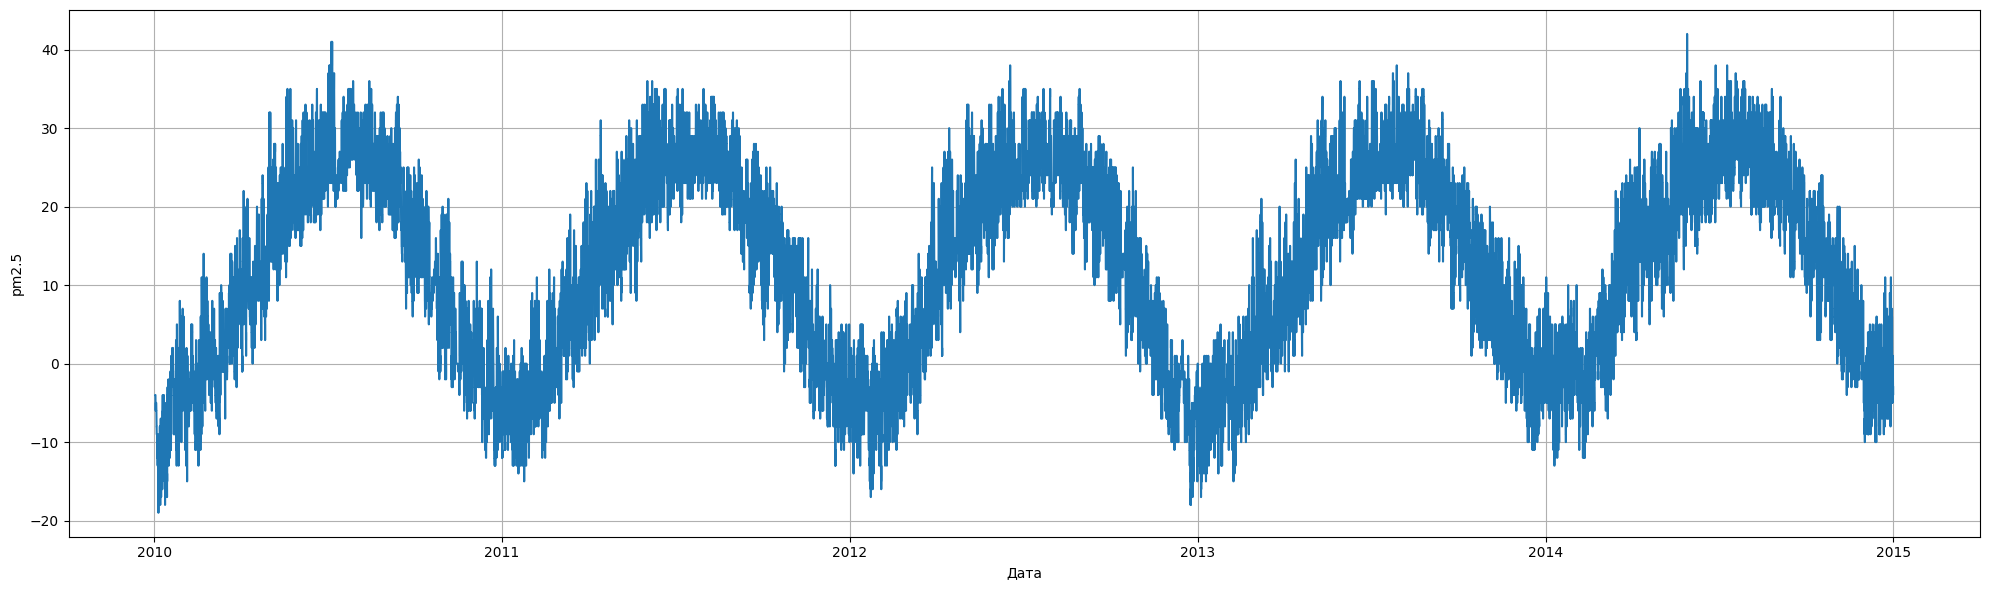

In [12]:
plt.figure(figsize=(20, 6))
plt.plot(df['TEMP'])
plt.xlabel('Дата')
plt.ylabel('pm2.5')
plt.grid(True)
plt.tight_layout()
plt.show()

In [29]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [30]:
decomposition = seasonal_decompose(df['pm2.5'], model='additive', period = 12)
trend = decomposition.trend
seasonal = decomposition.seasonal

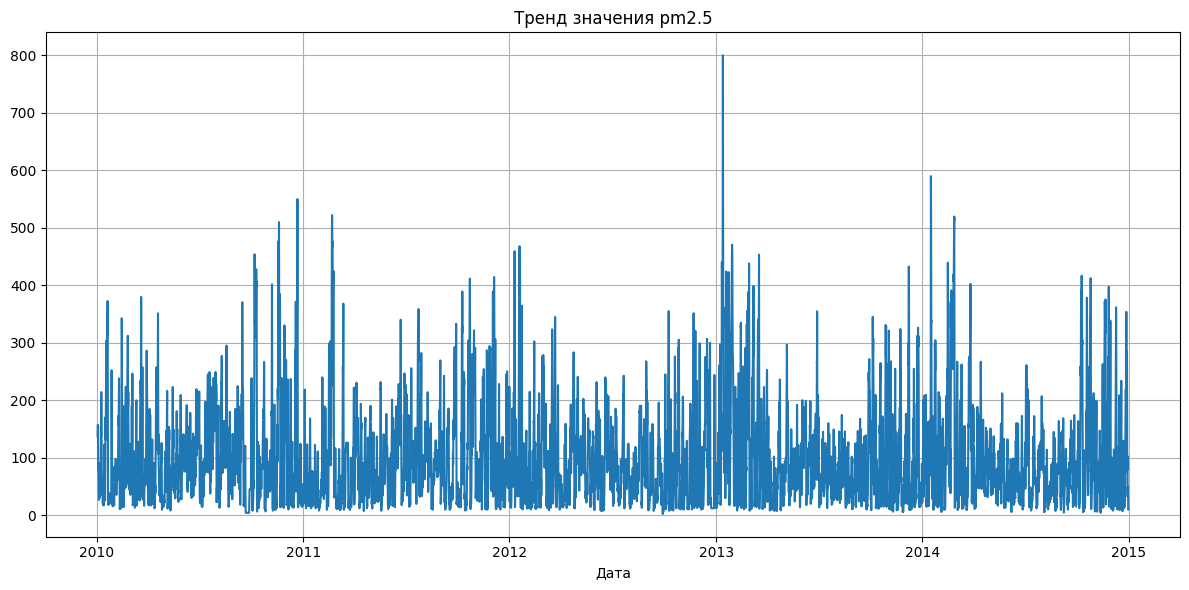

In [31]:
plt.figure(figsize=(12, 6))
plt.plot(trend)
plt.title('Тренд значения pm2.5')
plt.xlabel('Дата')
plt.grid(True)
plt.tight_layout()
plt.show()

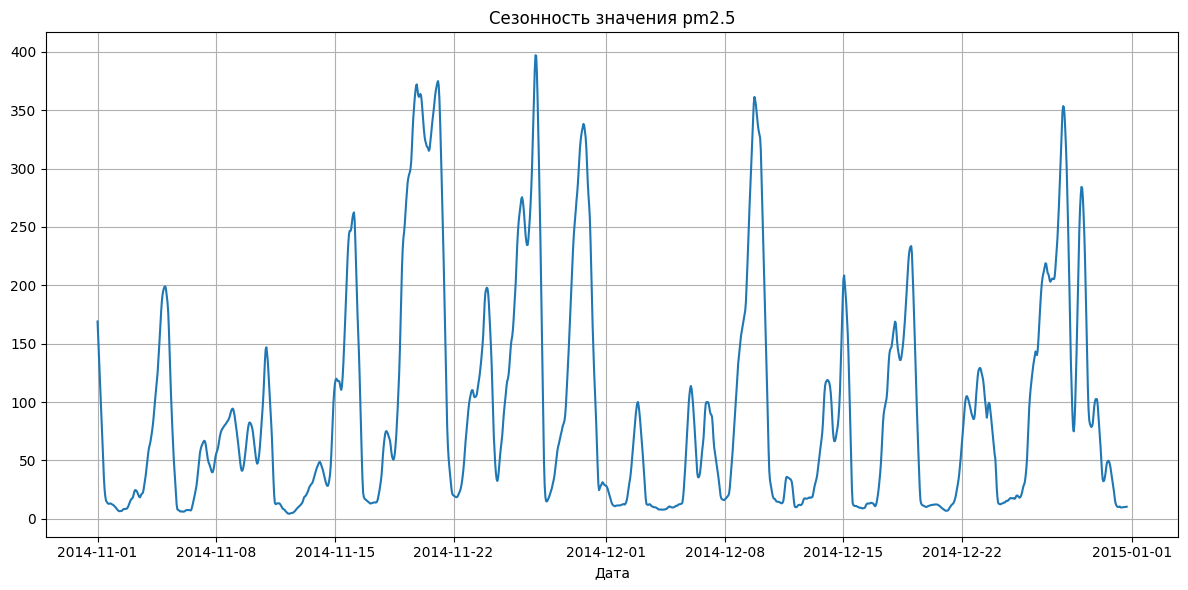

In [39]:
plt.figure(figsize=(12, 6))
plt.plot(trend[-1464:])
plt.title('Сезонность значения pm2.5')
plt.xlabel('Дата')
plt.grid(True)
plt.tight_layout()
plt.show()

# 2. Наивная модель

In [14]:
holdout_size = 48
train_size = len(df) - 48

In [17]:
train_data = df[:train_size]
test_data = df[train_size:]

In [18]:
test_data

,pm2.5,DEWP,TEMP,PRES,Iws,Is,Ir,NE,NW,SE,cv
time,,,,,,,,,,,
2014-12-30 00:00:00,189.0,-12,-2.0,1016.0,0.89,0,0,0,0,0,1
2014-12-30 01:00:00,97.0,-13,-2.0,1016.0,1.79,0,0,0,1,0,0
2014-12-30 02:00:00,81.0,-13,-4.0,1016.0,5.81,0,0,0,1,0,0
2014-12-30 03:00:00,28.0,-13,-2.0,1017.0,10.73,0,0,0,1,0,0
2014-12-30 04:00:00,25.0,-13,-5.0,1017.0,15.65,0,0,0,1,0,0
2014-12-30 05:00:00,9.0,-13,-3.0,1017.0,19.67,0,0,0,1,0,0
2014-12-30 06:00:00,9.0,-14,-2.0,1017.0,22.80,0,0,0,1,0,0
2014-12-30 07:00:00,13.0,-13,-3.0,1018.0,0.89,0,0,0,0,0,1
2014-12-30 08:00:00,17.0,-15,0.0,1019.0,1.78,0,0,0,0,0,1


Обычный наивный прогноз

In [19]:
df['Naive_Forecast'] = df['pm2.5'].shift(1)

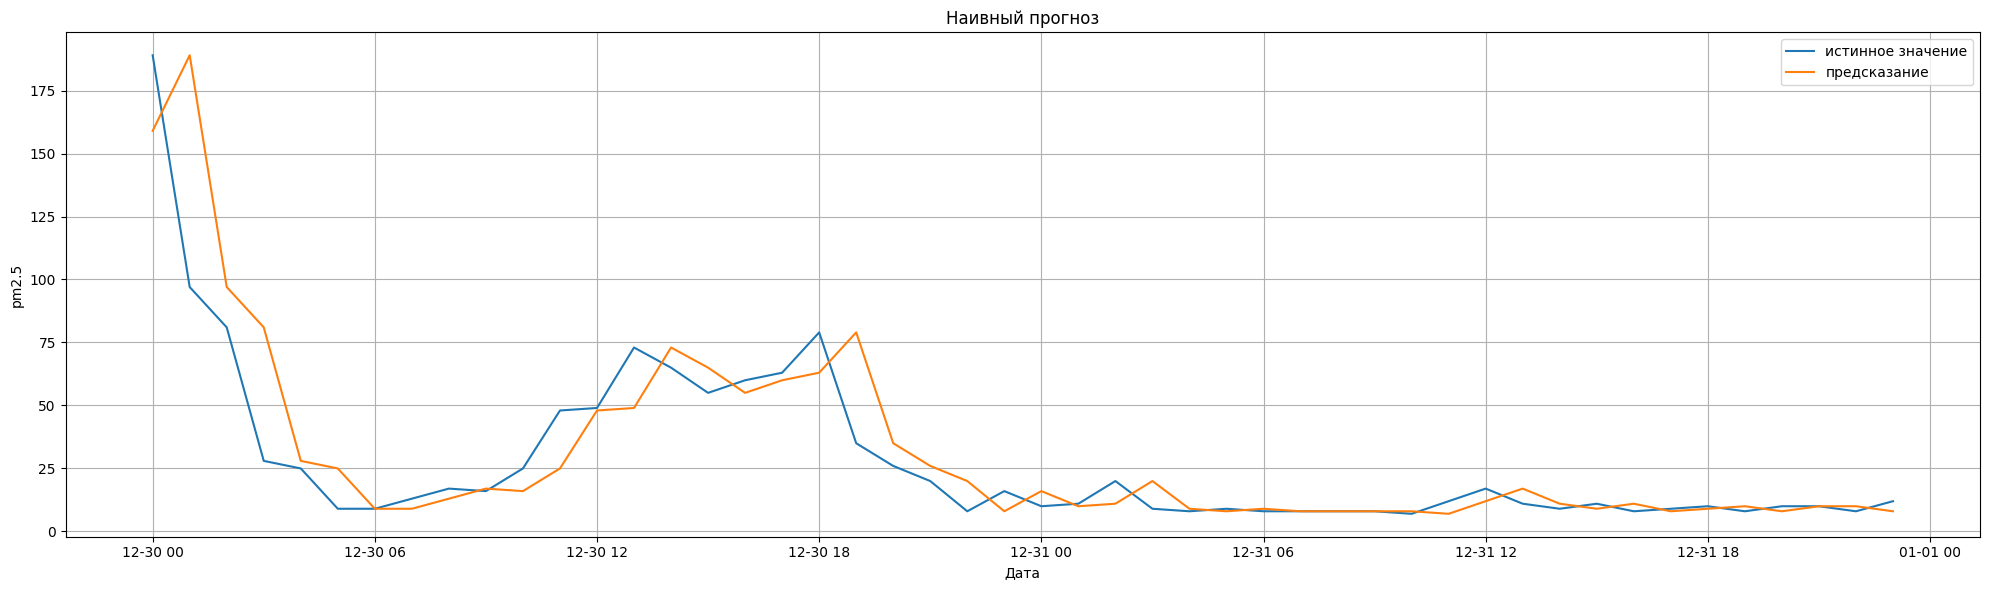

In [56]:
plt.figure(figsize=(20, 6))
plt.plot(df['pm2.5'][train_size:], label = 'истинное значение')
plt.plot(df['Naive_Forecast'][train_size:], label = 'предсказание')
plt.title('Наивный прогноз')
plt.xlabel('Дата')
plt.ylabel('pm2.5')
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

Наивный прогноз с шагом в одну неделю

In [28]:
rmse = np.sqrt(mean_squared_error(df['pm2.5'][train_size:], df['Naive_Forecast'][train_size:]))
print(f'Значение RMSE на тесте составило {rmse}')

Значение RMSE на тесте составило 18.82208366077819


In [52]:
df['Naive_S_Forecast'] = df['pm2.5'].shift(168)

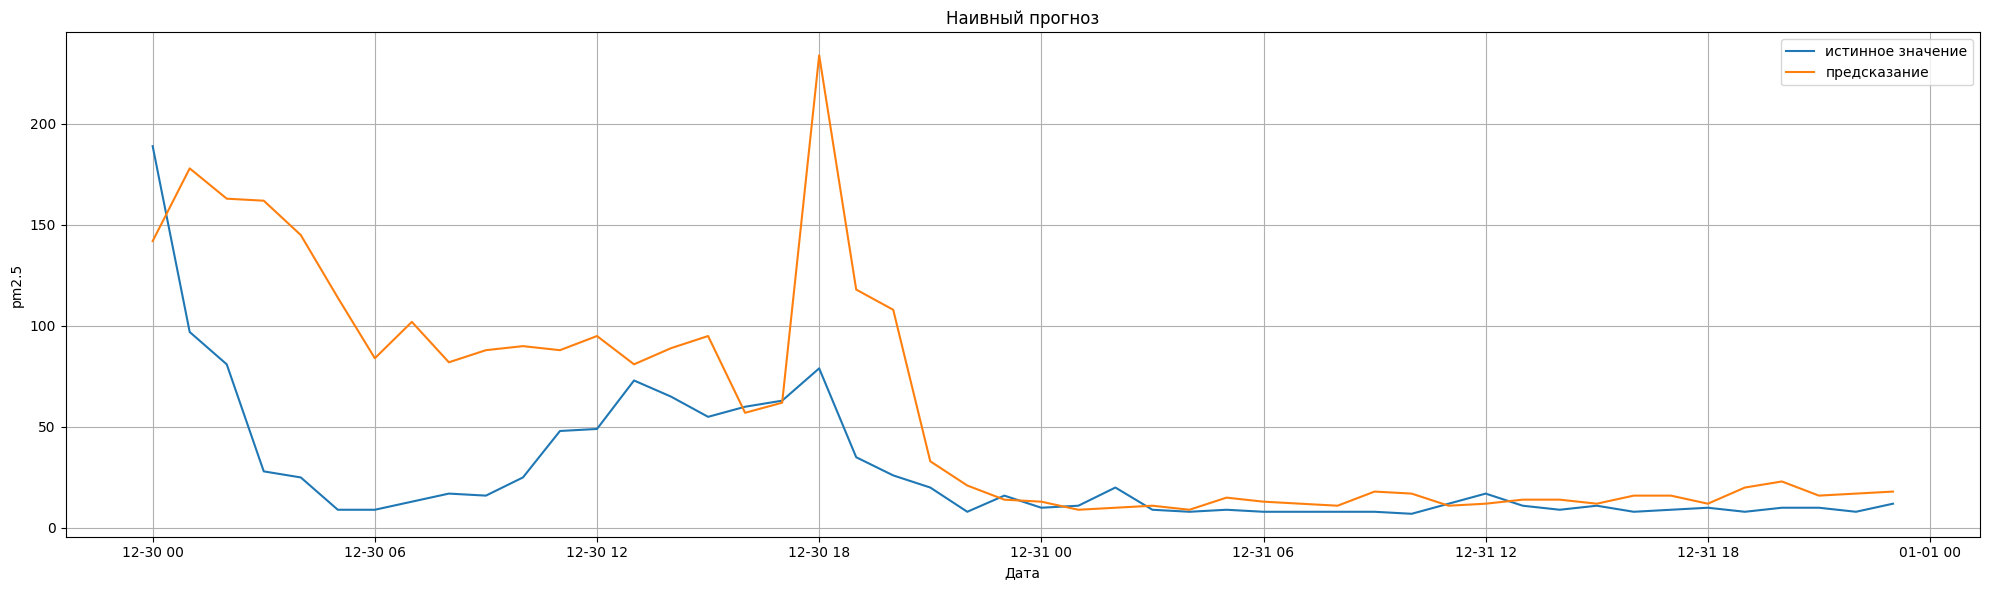

In [55]:
plt.figure(figsize=(20, 6))
plt.plot(df['pm2.5'][train_size:], label = 'истинное значение')
plt.plot(df['Naive_S_Forecast'][train_size:], label = 'предсказание')
plt.title('Наивный прогноз')
plt.xlabel('Дата')
plt.ylabel('pm2.5')
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

In [58]:
rmse = np.sqrt(mean_squared_error(df['pm2.5'][train_size:], df['Naive_S_Forecast'][train_size:]))
print(f'Значение RMSE на тесте составило {rmse}')

Значение RMSE на тесте составило 52.25119615855698


# 3. Экспоненциальное сглаживание

In [74]:
exp_train = train_data[['pm2.5']]
exp_test = test_data[['pm2.5']]

Simple exponential smoothing

In [62]:
def ses_optimizer(train_data, alphas, step=48):
    best_alpha, best_mae = None, float("inf")
    for alpha in alphas:
        ses_model = SimpleExpSmoothing(train_data).fit(smoothing_level=alpha)
        y_pred = ses_model.forecast(step)
        mse = mean_squared_error(exp_test, y_pred)
        if mse < best_mae:
            best_alpha, best_mse = alpha, mse
        print("alpha:", round(alpha, 2), "mse:", round(mse, 4))
    print("best_alpha:", round(best_alpha, 2), "best_mse:", round(best_mse, 4))
    return best_alpha, best_mse

In [63]:
alphas = np.arange(0.01, 1, 0.10)

In [64]:
best_alpha, best_mse = ses_optimizer(exp_train, alphas, step=len(test_data))

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/pandas/util/_decorators.py:210: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/pandas/util/_decorators.py:210: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)


alpha: 0.01 mse: 12826.5572
alpha: 0.11 mse: 10383.6296
alpha: 0.21 mse: 9779.2693


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/pandas/util/_decorators.py:210: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/pandas/util/_decorators.py:210: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)


alpha: 0.31 mse: 12017.7005


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/pandas/util/_decorators.py:210: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)


alpha: 0.41 mse: 14263.3629
alpha: 0.51 mse: 15915.4299


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/pandas/util/_decorators.py:210: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/pandas/util/_decorators.py:210: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)


alpha: 0.61 mse: 17021.4439


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/pandas/util/_decorators.py:210: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)


alpha: 0.71 mse: 17725.6344


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/pandas/util/_decorators.py:210: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)


alpha: 0.81 mse: 18130.1361


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/pandas/util/_decorators.py:210: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)


alpha: 0.91 mse: 18290.1289
best_alpha: 0.91 best_mse: 18290.1289


In [65]:
ses_model = SimpleExpSmoothing(exp_train).fit(smoothing_level=best_alpha)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/pandas/util/_decorators.py:210: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)


In [67]:
y_pred = pd.DataFrame(ses_model.predict(start=exp_test.index[0], end = exp_test.index[-1]))

In [80]:
y_pred.columns = ['pm2.5']
y_pred

,pm2.5
2014-12-30 00:00:00,159.146552
2014-12-30 01:00:00,159.146552
2014-12-30 02:00:00,159.146552
2014-12-30 03:00:00,159.146552
2014-12-30 04:00:00,159.146552
2014-12-30 05:00:00,159.146552
2014-12-30 06:00:00,159.146552
2014-12-30 07:00:00,159.146552
2014-12-30 08:00:00,159.146552
2014-12-30 09:00:00,159.146552


In [71]:
def plot_prediction(y_pred, label):
    plt.figure(figsize=(12, 6))
    plt.plot(exp_test['pm2.5'], label = "тест")
    plt.plot(y_pred['pm2.5'], label = "предсказание на тесте")
    plt.title(label)
    plt.xlabel('Дата')
    plt.grid(True)
    plt.tight_layout()
    plt.legend()
    plt.show()

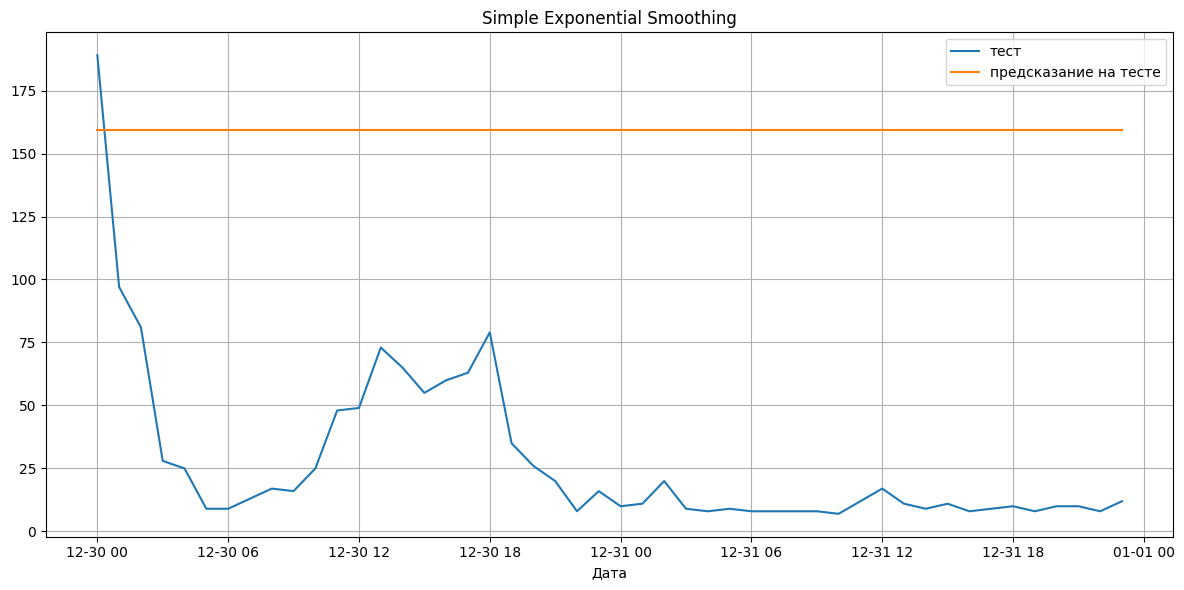

In [72]:
plot_prediction(y_pred, "Simple Exponential Smoothing")

In [73]:
rmse = np.sqrt(mean_squared_error(exp_test['pm2.5'], y_pred['pm2.5']))
print(f'Значение RMSE на тесте составило {rmse}')

Значение RMSE на тесте составило 135.24100319207014


Holt exponential smoothing

In [77]:
def des_optimizer(train_data, alphas, betas, step=len(test_data)):
    best_alpha, best_beta, best_mse = None, None, float("inf")
    for alpha in alphas:
        for beta in betas:
            des_model = ExponentialSmoothing(exp_train['pm2.5'], trend="add", dates = exp_train.index).fit(smoothing_level=alpha, smoothing_slope=beta)
            y_pred = des_model.forecast(step)
            mse = mean_squared_error(exp_test, y_pred)
            if mse < best_mse:
                best_alpha, best_beta, best_mse = alpha, beta, mse
            print("alpha:", round(alpha, 2), "beta:", round(beta, 2), "mse:", round(mse, 4))
    print("best_alpha:", round(best_alpha, 2), "best_beta:", round(best_beta, 2), "best_mse:", round(best_mse, 4))
    return best_alpha, best_beta, best_mse

In [79]:
alphas = np.arange(0.01, 1, 0.10)
betas = np.arange(0.01, 1, 0.10)
best_alpha, best_beta, best_mse = des_optimizer(exp_train, alphas, betas, step=len(exp_test))

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


alpha: 0.01 beta: 0.01 mse: 23032.7068


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


alpha: 0.01 beta: 0.11 mse: 46372.7968


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


alpha: 0.01 beta: 0.21 mse: 13313.6902


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


alpha: 0.01 beta: 0.31 mse: 227714.1554


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


alpha: 0.01 beta: 0.41 mse: 150000.7012


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


alpha: 0.01 beta: 0.51 mse: 1364.3817


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


alpha: 0.01 beta: 0.61 mse: 5372.3385


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


alpha: 0.01 beta: 0.71 mse: 22175.4873


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


alpha: 0.01 beta: 0.81 mse: 32897.7031


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


alpha: 0.01 beta: 0.91 mse: 8762.2172


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


alpha: 0.11 beta: 0.01 mse: 9782.0309


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


alpha: 0.11 beta: 0.11 mse: 5760.628


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


alpha: 0.11 beta: 0.21 mse: 39696.8073


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


alpha: 0.11 beta: 0.31 mse: 77302.9281


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


alpha: 0.11 beta: 0.41 mse: 23374.8605


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


alpha: 0.11 beta: 0.51 mse: 964785.1133


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


alpha: 0.11 beta: 0.61 mse: 3156861.0094


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


alpha: 0.11 beta: 0.71 mse: 4627531.637


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


alpha: 0.11 beta: 0.81 mse: 4301652.4687


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


alpha: 0.11 beta: 0.91 mse: 2946461.3289


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


alpha: 0.21 beta: 0.01 mse: 8584.8115


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


alpha: 0.21 beta: 0.11 mse: 1016.3574


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


alpha: 0.21 beta: 0.21 mse: 64197.834


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


alpha: 0.21 beta: 0.31 mse: 605987.8955


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


alpha: 0.21 beta: 0.41 mse: 1221540.1969


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


alpha: 0.21 beta: 0.51 mse: 1173793.2951


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


alpha: 0.21 beta: 0.61 mse: 840962.5436


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


alpha: 0.21 beta: 0.71 mse: 625064.9124


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


alpha: 0.21 beta: 0.81 mse: 588175.8127


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


alpha: 0.21 beta: 0.91 mse: 698039.6391


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


alpha: 0.31 beta: 0.01 mse: 11488.433


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


alpha: 0.31 beta: 0.11 mse: 20911.1497


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


alpha: 0.31 beta: 0.21 mse: 239954.3456


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


alpha: 0.31 beta: 0.31 mse: 603742.6251


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


alpha: 0.31 beta: 0.41 mse: 697851.3997


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


alpha: 0.31 beta: 0.51 mse: 653812.7982


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


alpha: 0.31 beta: 0.61 mse: 635693.4494


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


alpha: 0.31 beta: 0.71 mse: 634031.453


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


alpha: 0.31 beta: 0.81 mse: 579914.6719


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


alpha: 0.31 beta: 0.91 mse: 440588.7661


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


alpha: 0.41 beta: 0.01 mse: 14505.0531


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


alpha: 0.41 beta: 0.11 mse: 45594.9545


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


alpha: 0.41 beta: 0.21 mse: 268189.3963


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


alpha: 0.41 beta: 0.31 mse: 481727.6634


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


alpha: 0.41 beta: 0.41 mse: 528962.8242


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


alpha: 0.41 beta: 0.51 mse: 500153.9073


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


alpha: 0.41 beta: 0.61 mse: 427440.5843


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


alpha: 0.41 beta: 0.71 mse: 315555.2974


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


alpha: 0.41 beta: 0.81 mse: 196230.7116


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


alpha: 0.41 beta: 0.91 mse: 106045.0916


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


alpha: 0.51 beta: 0.01 mse: 16744.7644


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


alpha: 0.51 beta: 0.11 mse: 59251.7367


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


alpha: 0.51 beta: 0.21 mse: 254428.2042


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


alpha: 0.51 beta: 0.31 mse: 399074.5911


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


alpha: 0.51 beta: 0.41 mse: 413936.9349


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


alpha: 0.51 beta: 0.51 mse: 358976.6153


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


alpha: 0.51 beta: 0.61 mse: 276119.8131


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


alpha: 0.51 beta: 0.71 mse: 198426.7154


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


alpha: 0.51 beta: 0.81 mse: 146787.7822


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


alpha: 0.51 beta: 0.91 mse: 125234.6302


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


alpha: 0.61 beta: 0.01 mse: 18242.0463


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


alpha: 0.61 beta: 0.11 mse: 65256.0457


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


alpha: 0.61 beta: 0.21 mse: 234485.9531


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


alpha: 0.61 beta: 0.31 mse: 340324.3515


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


alpha: 0.61 beta: 0.41 mse: 339679.6136


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


alpha: 0.61 beta: 0.51 mse: 290541.7342


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


alpha: 0.61 beta: 0.61 mse: 236133.6987


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


alpha: 0.61 beta: 0.71 mse: 198946.9901


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


alpha: 0.61 beta: 0.81 mse: 185060.8879


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


alpha: 0.61 beta: 0.91 mse: 191653.9393


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


alpha: 0.71 beta: 0.01 mse: 19190.3126


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


alpha: 0.71 beta: 0.11 mse: 67261.2534


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


alpha: 0.71 beta: 0.21 mse: 216169.4202


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


alpha: 0.71 beta: 0.31 mse: 300057.3423


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


alpha: 0.71 beta: 0.41 mse: 297205.4438


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


alpha: 0.71 beta: 0.51 mse: 261640.6398


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


alpha: 0.71 beta: 0.61 mse: 227789.0972


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


alpha: 0.71 beta: 0.71 mse: 207830.5704


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


alpha: 0.71 beta: 0.81 mse: 201148.9177


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


alpha: 0.71 beta: 0.91 mse: 201777.0813


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


alpha: 0.81 beta: 0.01 mse: 19730.8886


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


alpha: 0.81 beta: 0.11 mse: 67034.565


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


alpha: 0.81 beta: 0.21 mse: 199750.0667


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


alpha: 0.81 beta: 0.31 mse: 269357.1742


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


alpha: 0.81 beta: 0.41 mse: 265863.0341


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


alpha: 0.81 beta: 0.51 mse: 236503.418


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


alpha: 0.81 beta: 0.61 mse: 206973.6365


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


alpha: 0.81 beta: 0.71 mse: 183184.7085


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


alpha: 0.81 beta: 0.81 mse: 161884.6865


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


alpha: 0.81 beta: 0.91 mse: 137618.214


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


alpha: 0.91 beta: 0.01 mse: 19940.5535


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


alpha: 0.91 beta: 0.11 mse: 65225.0618


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


alpha: 0.91 beta: 0.21 mse: 183530.6942


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


alpha: 0.91 beta: 0.31 mse: 240468.5039


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


alpha: 0.91 beta: 0.41 mse: 232338.1491


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


alpha: 0.91 beta: 0.51 mse: 199976.204


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


alpha: 0.91 beta: 0.61 mse: 163472.8802


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


alpha: 0.91 beta: 0.71 mse: 127051.7784


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


alpha: 0.91 beta: 0.81 mse: 89986.3645


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


alpha: 0.91 beta: 0.91 mse: 53091.5679
best_alpha: 0.21 best_beta: 0.11 best_mse: 1016.3574


In [83]:
des_model = ExponentialSmoothing(exp_train, trend="add", dates = exp_train.index).fit(smoothing_level=best_alpha,
                                                         smoothing_slope=best_beta)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


In [87]:
y_pred = pd.DataFrame(des_model.predict(start=exp_test.index[0], end = exp_test.index[-1]))
y_pred.columns = ['pm2.5']

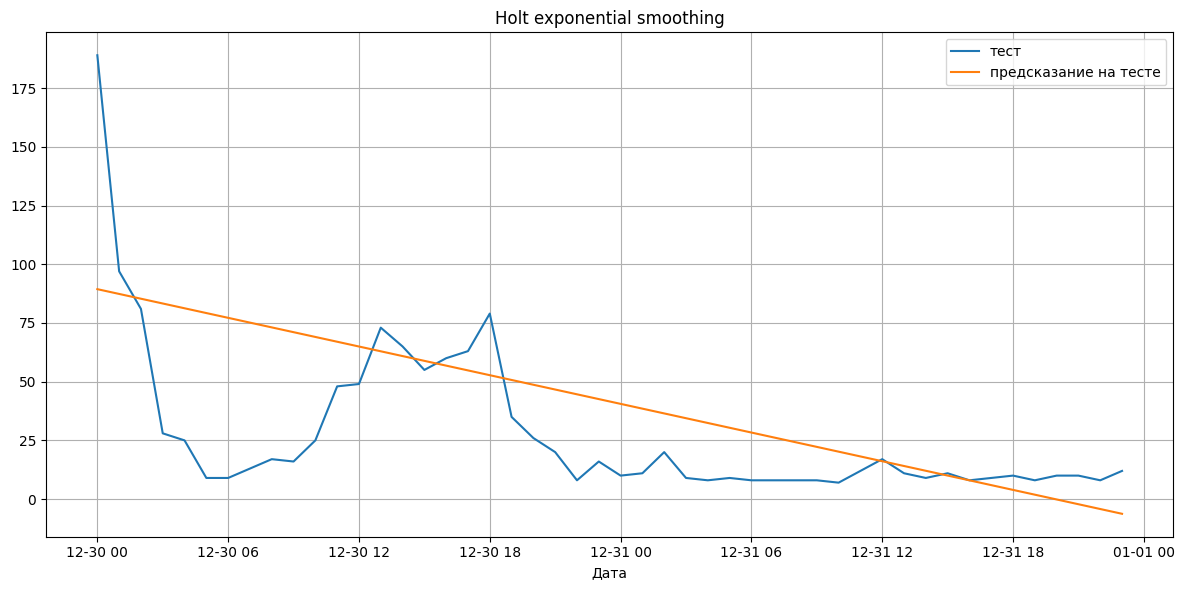

In [88]:
plot_prediction(y_pred, "Holt exponential smoothing")

In [89]:
rmse = np.sqrt(mean_squared_error(exp_test['pm2.5'], y_pred['pm2.5']))
print(f'Значение RMSE на тесте составило {rmse}')

Значение RMSE на тесте составило 31.88036074761768


In [226]:
tes_model = ExponentialSmoothing(exp_train, dates = exp_train.index, trend="add", seasonal="add", seasonal_periods=12).\
            fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Тройной метод экспоненциального сглаживания

In [227]:
y_pred = pd.DataFrame(tes_model.predict(start=exp_test.index[0], end = exp_test.index[-1]))
y_pred.columns = ['pm2.5']

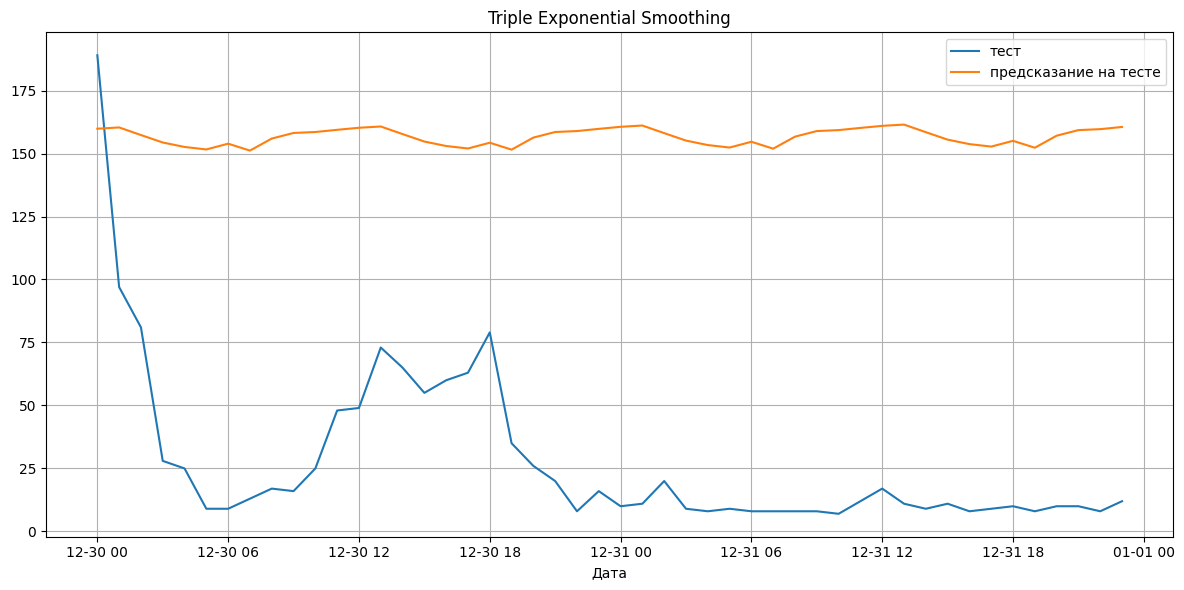

In [228]:
plot_prediction(y_pred, "Triple Exponential Smoothing")

In [229]:
rmse = np.sqrt(mean_squared_error(exp_test['pm2.5'], y_pred['pm2.5']))
print(f'Значение RMSE на тесте составило {rmse}')

Значение RMSE на тесте составило 132.76657845415227


# 4. AR, MA, ARMA, ARIMA

In [231]:
from statsmodels.tsa.arima.model import ARIMA

Модель авторегрессии

In [232]:
AR_model = ARIMA(exp_train['pm2.5'], order = (2, 0, 0), dates = train_data.index).fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


In [233]:
y_pred = pd.DataFrame(AR_model.forecast(len(test_data)))
y_pred.columns = ['pm2.5']

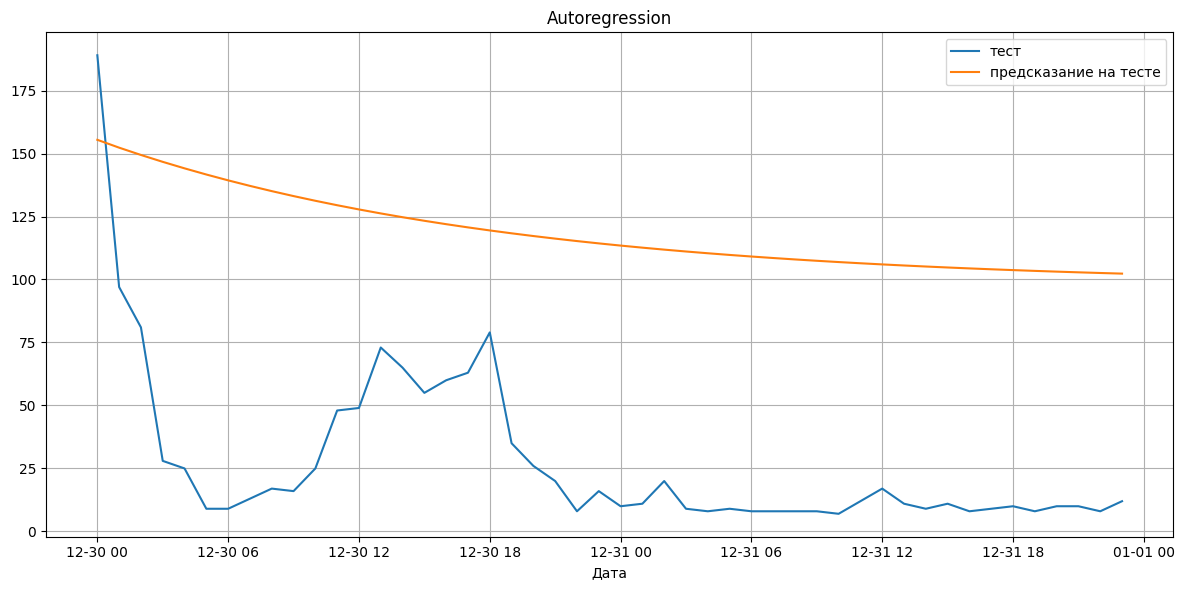

In [234]:
plot_prediction(y_pred, "Autoregression")

In [235]:
rmse = np.sqrt(mean_squared_error(exp_test['pm2.5'], y_pred['pm2.5']))
print(f'Значение RMSE на тесте составило {rmse}')

Значение RMSE на тесте составило 94.6110658644622


Модель скользящего среднего

In [237]:
MA_model = ARIMA(exp_train['pm2.5'], order = (0, 0, 2), dates = train_data.index).fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


In [238]:
y_pred = pd.DataFrame(MA_model.forecast(len(test_data)))
y_pred.columns = ['pm2.5']

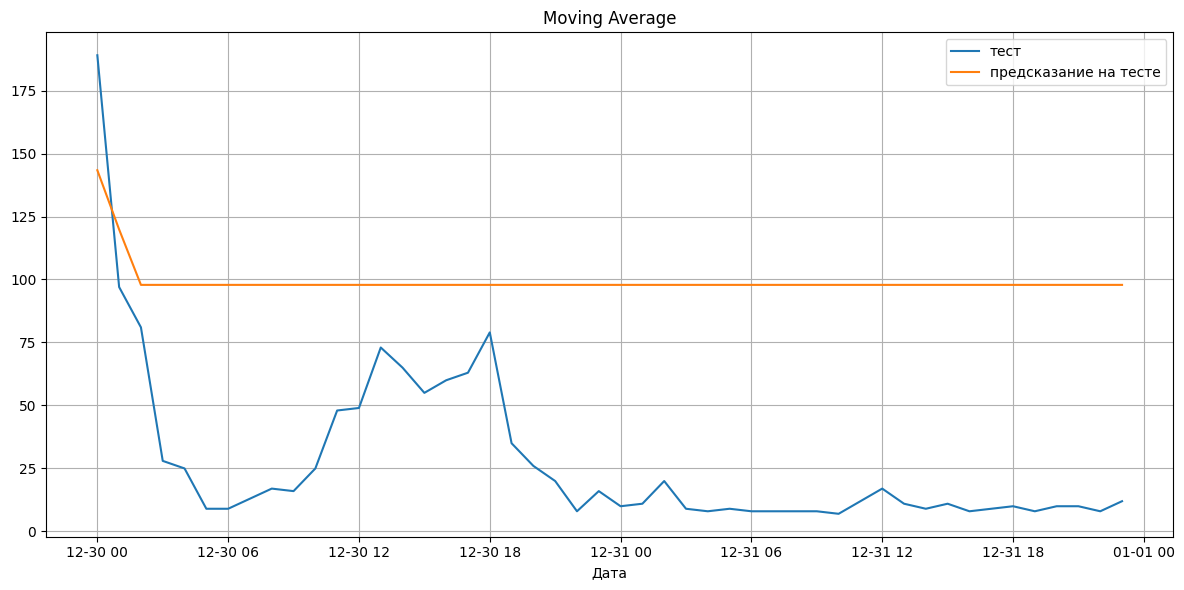

In [239]:
plot_prediction(y_pred, "Moving Average")

In [240]:
rmse = np.sqrt(mean_squared_error(exp_test['pm2.5'], y_pred['pm2.5']))
print(f'Значение RMSE на тесте составило {rmse}')

Значение RMSE на тесте составило 76.55115768443238


Модель ARMA

In [245]:
ARMA_model = ARIMA(exp_train, order = (3, 0, 1), dates = train_data.index).fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


In [246]:
y_pred = pd.DataFrame(ARMA_model.forecast(len(test_data)))
y_pred.columns = ['pm2.5']

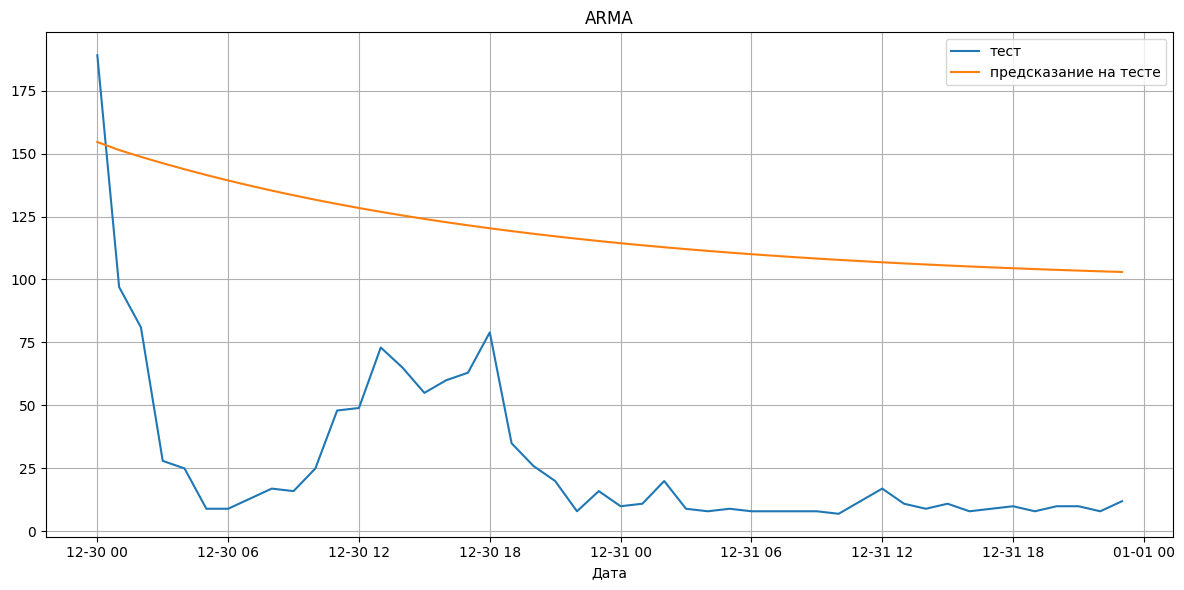

In [247]:
plot_prediction(y_pred, "ARMA")

модель ARIMA

In [255]:
ARIMA_model = ARIMA(exp_train['pm2.5'], order = (3, 1, 2), dates = train_data.index).fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [256]:
y_pred = pd.DataFrame(ARIMA_model.forecast(len(test_data)))
y_pred.columns = ['pm2.5']

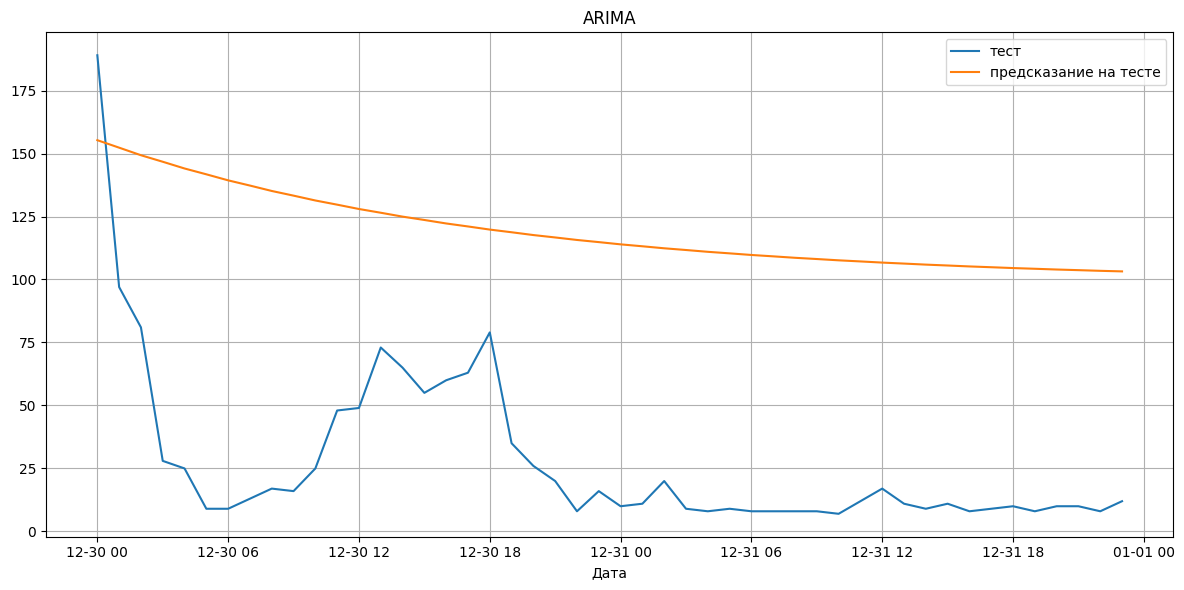

In [257]:
plot_prediction(y_pred, "ARIMA")

In [258]:
rmse = np.sqrt(mean_squared_error(exp_test['pm2.5'], y_pred['pm2.5']))
print(f'Значение RMSE на тесте составило {rmse}')

Значение RMSE на тесте составило 95.06453602137017


In [260]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 12.7 MB/s eta 0:00:00


In [262]:
from pmdarima.arima import auto_arima

#arima = auto_arima(exp_train['pm2.5'],
#                   seasonal = False,
#                   maxiter = 100,
#                   trace = True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=399980.655, Time=46.17 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=552688.788, Time=1.11 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=401733.024, Time=1.35 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=500705.703, Time=6.42 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=399990.402, Time=4.24 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=399991.691, Time=8.73 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=399968.603, Time=4.76 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=inf, Time=52.86 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=inf, Time=76.09 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=399967.272, Time=53.03 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=inf, Time=69.79 sec
 ARIMA(4,0,3)(0,0,0)[0]             : AIC=399966.875, Time=48.92 sec
 ARIMA(5,0,3)(0,0,0)[0]             : AIC=inf, Time=132.71 sec
 ARIMA(4,0,4)(0,0,0)[0]             : AIC=inf, Time=175.27 sec
 ARIMA(3,0,4)(0,0,0)[0]       

In [263]:
ARIMA_model = ARIMA(exp_train['pm2.5'], order = (4, 0, 5), dates = train_data.index).fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


In [264]:
y_pred = pd.DataFrame(ARIMA_model.forecast(len(test_data)))
y_pred.columns = ['pm2.5']

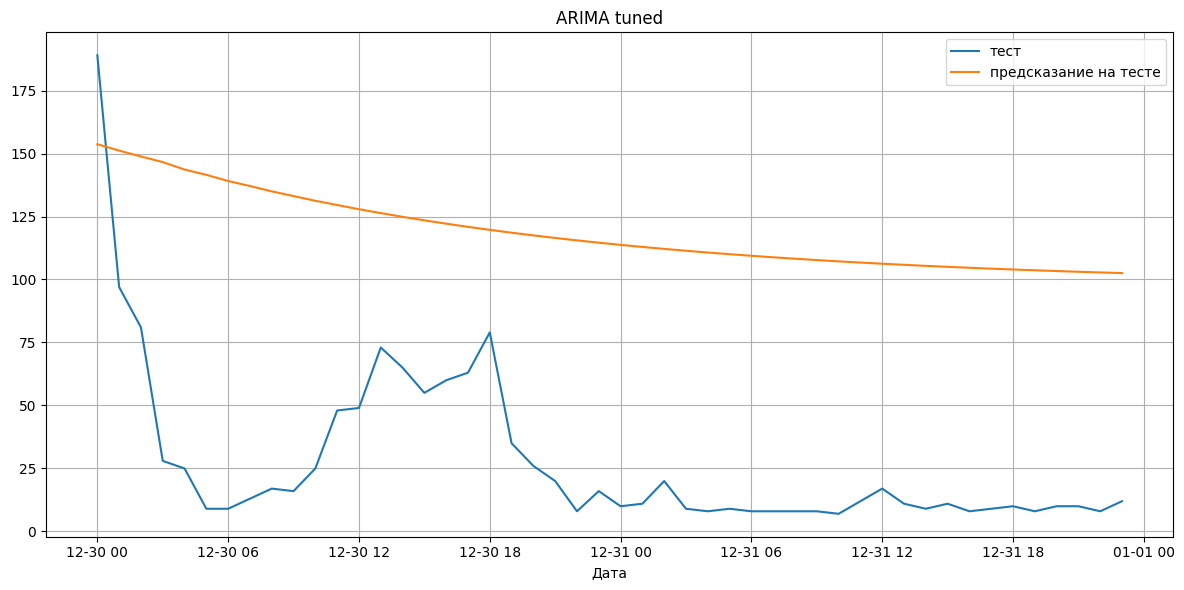

In [265]:
plot_prediction(y_pred, "ARIMA tuned")

In [266]:
rmse = np.sqrt(mean_squared_error(exp_test['pm2.5'], y_pred['pm2.5']))
print(f'Значение RMSE на тесте составило {rmse}')

Значение RMSE на тесте составило 94.75128100795182


In [267]:
arima = auto_arima(exp_train['pm2.5'],
                   seasonal = True,
                   trace = True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=399401.324, Time=67.25 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=519280.116, Time=1.14 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=401327.278, Time=1.42 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=471283.093, Time=14.47 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=552688.788, Time=0.89 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=399406.998, Time=29.50 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=399410.037, Time=18.84 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=399404.620, Time=50.10 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=399405.320, Time=28.88 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=399433.127, Time=16.64 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=399402.048, Time=38.57 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=399409.299, Time=51.99 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=399405.275, Time=49.01 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=399980.655, Time=19.0

Модель SARIMA(x) неэффективна для данной задачи